# Assignment 4: Pytorch Segmentation
For this assignment, we're goining to use Deep Learning for a new task: semantic segmentation , instead of classification we've been doing. We will also use some common techniques in Deep Learning like pretraining.

## Short recap of  semantic segmentation
The goal of semantic segmentation is to classify each pixel of the image to a corresponding class of what the pixel represent. One major deference between semantic segmentation and classification is that for semantic segmentation, model output label for each pixel instead of a single label for the whole image

### Metrics
In semantic segmentations, we will average pixel-wise accuracy and IoU to benchmark semantic segmentation methods. Here we provide, the code for Evaluation

In [ ]:
import numpy as np

def _hist(pred, gt, n_class):
#     mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * gt.astype(int) +
        pred, minlength=n_class ** 2
    ).reshape(n_class, n_class)
    return hist


def metrics(preds, gts, n_class):
    hist = np.zeros((n_class, n_class))
    for pred, gt in zip(preds, gts):
        hist += _hist(pred.flatten(), gt.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    iou = np.diag(hist) / (
        hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
    )
    mean_iou = np.nanmean(iou)
    return acc, mean_iou

## CMP Facade DB
In this assignment, we use a new dataset named: CMP Facade Database for semantic segmentation. This dataset is made up with 606 rectified images of the facade of various buildings. The facades are from different cities arount the world with different architectural styles.

CMP Facade DB include 12 semantic classes:

* facade 
* molding
* cornice
* pillar
* window
* door
* sill
* blind
* balcony
* shop
* deco
* background

In this assignment, we should use a model to classify each pixel in images to one of these 12 classes.

For more detail about CMP Facade Dataset, if you are intereseted, please check: https://cmp.felk.cvut.cz/~tylecr1/facade/

## Visualize of the Dataset

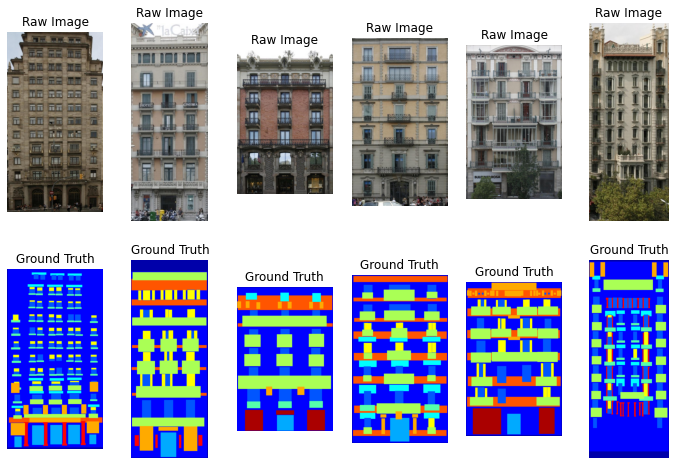

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import PI

idxs = [1, 2, 5, 6, 7, 8]
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8))
for i, idx in enumerate(idxs):
    pic = plt.imread("dataset/base/cmp_b000{}.jpg".format(idx))
    label = plt.imread("dataset/base/cmp_b000{}.png".format(idx), format="PNG")

    axes[0][i].axis('off')
    axes[0][i].imshow(pic)
    axes[0][i].set_title("Raw Image")

    axes[1][i].imshow(label)
    axes[1][i].axis('off')
    axes[1][i].set_title("Ground Truth")


## Prepare

In [ ]:
import torch
import copy

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


## Build Dataset Class in Pytorch

In [ ]:
import torch
import PIL
from torch.utils.data import Dataset
import os
import os.path as osp
import torchvision.transforms as transforms
from PIL import Image


def get_full_list(
    root_dir,
    base_dir="base",
    extended_dir="extended",
):
    data_list = []
    for name in [base_dir, extended_dir]:
        data_dir = osp.join(
            root_dir, name
        )
        data_list += sorted(
            osp.join(data_dir, img_name) for img_name in
            filter(
                lambda x: x[-4:] == '.jpg',
                os.listdir(data_dir)
            )
        )
    return data_list

class CMP_Facade_DB(Dataset):
    def __init__(
        self,
        data_list
    ):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)
                
    def __getitem__(self, i):
        # input and target images
        in_name = self.data_list[i]
        gt_name = self.data_list[i].replace('.jpg','.png')
    
        # process the images
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        transf = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
        in_image = transf(
            Image.open(in_name).convert('RGB')
        )
        gt_im = Image.open(gt_name)
        
        gt_label = torch.LongTensor(
            np.frombuffer(gt_im.tobytes(), dtype=np.ubyte).reshape(
                in_image.shape[1:]
            )
        ) - 1

        return in_image, gt_label
    
    def revert_input(self, img, label):
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))
        std_img = np.array([0.229, 0.224, 0.225]).reshape((1, 1, -1))
        mean_img = np.array([0.485, 0.456, 0.406]).reshape((1, 1, -1))
        img *= std_img
        img += mean_img
        label = label.cpu().numpy()
        return img, label + 1

TRAIN_SIZE = 500
VAL_SIZE = 30
TEST_SIZE = 70
full_data_list = get_full_list("dataset")

train_data_set = CMP_Facade_DB(full_data_list[: TRAIN_SIZE])
val_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE])
test_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE + VAL_SIZE:])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

Training Set Size: 500
Validation Set Size: 30
Test Set Size: 76


## Fully Convolutional Networks for Semantic Segmentation

We've seen that CNNs are powerful models to get hiereachical visual features in Deep Learning. There we are going to explore the classical work: "Fully Convolutional Networks for Semantic Segmentation"(FCN).

Though we've already used CNN models for image classifications in the previous assignemtn, those models have one major drawback: Those model take input with fixed shape and output a single vector. However, in semantic segmentation, we want the model to be able to process image with arbitary shape and predict the label map with the same shape as the input image.

In FCN, the model utilize the Transpose Convolution layers, which we've already learned during the lecture, to make it happen. For the overal introduction of Transpose Convolution and Fully Convolutional Networks, please review the lecture recording and lecture slides on Canvas(Lecture 10).

Here we do not cover all the details in FCN. If you need more reference, you can check the original paper: https://arxiv.org/pdf/1411.4038.pdf and some other materials online.

Besides of transpose Convolution, there are also some difference compared with the models we've been working on:

* Use 1x1 Convolution to replace fully connected layers to output score for each class.
* Use skip connection to combine high-level feature and local feature.


### Naive FCN: FCN-32s (30%)

In this section, we first try to implement naive variant of FCN without skip connection: FCN-32s. Here we use FCN-32s with VGG-16 architecture for feature encoding.

Compared with VGG-16, FCN-32s only replace the fully connecteed layers with 1x1 convolution and add a Transpose Convolution at the end to output dense prediction.


FC-32s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1(except conv1_1. conv1_1 should use padding = 100)

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)] 
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool3(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool3(2,2)]


The following Conv use kernel size = 7, stride = 1, padding = 0
* [fc6=conv(512, 4096, 7)-relu-dropout2d]

The following Conv use kernel size = 1, stride = 1, padding = 0
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The transpose convolution: kernal size = 64, stride = 32, bias = False
* [transpose_conv(n_class, n_class)]

**Note: The output of the transpose convlution might not have the same shape as the input, take [19: 19 + input_image_width], [19: 19 + input_image_height] for width and height dimension of the output to get the output with the same shape as the input**

**It's expected that you model perform very poor in this section**

**Try to name the layers use the name provide above to ensure the next section works correctly, and use a new nn.RELU() for each activation**

In [ ]:
import torch.nn as nn

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN32s(nn.Module):
    def __init__(self, n_class=12):
        super(FCN32s, self).__init__()
        
        # YOUR CODE HERE
        self.conv1_1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3,padding=100,stride=1)
        self.relu1_1 = nn.ReLU(inplace = True)
        self.conv1_2 = nn.Conv2d(in_channels = 64, out_channels = 64,kernel_size=3,padding=1,stride=1)
        self.relu1_2 = nn.ReLU(inplace = True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride = 2, ceil_mode=True)

        self.conv2_1 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3,padding=1,stride=1)
        self.relu2_1 = nn.ReLU(inplace = True)
        self.conv2_2 = nn.Conv2d(in_channels = 128, out_channels = 128,kernel_size=3,padding=1,stride=1)
        self.relu2_2 = nn.ReLU(inplace = True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.conv3_1 = nn.Conv2d(in_channels = 128, out_channels = 256,kernel_size=3,padding=1,stride=1)
        self.relu3_1 = nn.ReLU(inplace = True)
        self.conv3_2 = nn.Conv2d(in_channels = 256, out_channels = 256,kernel_size=3,padding=1,stride=1)
        self.relu3_2 = nn.ReLU(inplace = True)
        self.conv3_3 = nn.Conv2d(in_channels = 256, out_channels = 256,kernel_size=3,padding=1,stride=1)
        self.relu3_3 = nn.ReLU(inplace = True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride = 2, ceil_mode=True)

        self.conv4_1 = nn.Conv2d(in_channels = 256, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu4_1 = nn.ReLU(inplace = True)
        self.conv4_2 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu4_2 = nn.ReLU(inplace = True)
        self.conv4_3 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu4_3 = nn.ReLU(inplace = True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride = 2, ceil_mode=True)

        self.conv5_1 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu5_1 = nn.ReLU(inplace = True)
        self.conv5_2 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu5_2 = nn.ReLU(inplace = True)
        self.conv5_3 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu5_3 = nn.ReLU(inplace = True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride = 2, ceil_mode=True)  

        self.fc6 = nn.Conv2d(in_channels = 512, out_channels = 4096,kernel_size=7,padding=0,stride=1)
        self.relu6 = nn.ReLU(inplace = True)
        self.drop6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(in_channels = 4096,  out_channels = 4096,kernel_size=1,padding=0,stride=1)
        self.relu7 = nn.ReLU(inplace = True)
        self.drop7 = nn.Dropout2d()

        self.score_conv = nn.Conv2d( in_channels = 4096,  out_channels = 12, kernel_size=1)
        self.transpose_conv = nn.ConvTranspose2d(12,12,kernel_size=64,stride=32,bias=False)

        self._initialize_weights()
        

    def _initialize_weights(self):
        for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 m.weight.data.zero_()
#                 if m.bias is not None:
#                     m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):

        # YOUR CODE HERE

        part_11 = self.relu1_1(self.conv1_1(x))
        part_22 = self.conv1_2(part_11)
        layer1 = self.pool1(self.relu1_2(part_22))
        
        part_21 = self.relu2_1(self.conv2_1(layer1))
        part_22 = self.conv2_2(part_21)
        layer2 = self.pool2(self.relu2_2(part_22))

        part_31 = self.relu3_1(self.conv3_1(layer2))
        part_32 = self.relu3_2(self.conv3_2(part_31))
        part_33 = self.relu3_3(self.conv3_3(part_32))
        layer3 = self.pool3(part_33)

        part_41 = self.relu4_1(self.conv4_1(layer3))
        part_42 = self.relu4_2(self.conv4_2(part_41))
        part_43 = self.relu4_3(self.conv4_3(part_42))
        layer4 = self.pool4(part_43)

        part_51 = self.conv5_2(self.relu5_1(self.conv5_1(layer4)))
        part_52 = self.conv5_3(self.relu5_2(part_51))
        layer5 = self.pool5(self.relu5_3(part_52))

        layer6 = self.drop6(self.relu6(self.fc6(layer5)))

        layer7 = self.drop7(self.relu7(self.fc7(layer6)))

        score = self.score_conv(layer7)

        h = self.transpose_conv(score)

        to_return = h[:, :, 19:(19 + x.size()[2]), 19:(19 + x.size()[3])]
        
        h = to_return 

        return h

    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())


In [ ]:
# You can change it if you want
lr = 1e-4
weight_decay = 2e-5

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=1, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=1, shuffle=True
)

In [ ]:
def Evaluate(
    val_loader,
    model,
    current_best,
    n_class=12
):
    val_loss = 0
    visualizations = []
    preds, gts = [], []
    
    model.eval()
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            score = model(data)

        pred = score.max(1)[1].cpu().numpy()
        gt = target.cpu().numpy()
        preds.append(pred)
        gts.append(gt)

    avg_acc, mean_iou = metrics(
        preds, gts, n_class)

    if mean_iou > current_best["IoU"]:
        current_best["IoU"] = mean_iou
        current_best["model"] = copy.deepcopy(model)

    return avg_acc, mean_iou, current_best

def Train(
    model,
    loss_func,
    optim,
    scheduler,
    epochs,
    train_loader,
    val_lodaer,
    test_loader,
    display_interval = 100
):

    current_best = {
        "IoU": 0,
        "model": model
    }
    avg_acc, mean_iou, current_best = Evaluate(
        val_loader,
        model,
        current_best
    )
    
    print("Init Model")
    print("Avg Acc: {:.4}, Mean IoU: {:.4}".format(
        avg_acc, mean_iou
    ))
    for i in range(epochs):
        print("Epochs: {}".format(i))
        total_loss = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to("cuda:0"), target.to("cuda:0")
            optim.zero_grad()

            score = model(data)
            loss = loss_func(score, target.squeeze(1))
            loss_data = loss.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            loss.backward()
            optim.step()
            total_loss += loss.item()
            if batch_idx % display_interval == 0 and batch_idx != 0:
                print("{} / {}, Current Avg Loss:{:.4}".format(
                    batch_idx, len(train_loader), total_loss / (batch_idx + 1)
                ))
            
        
        total_loss /= len(train_loader)
        model.eval()
        avg_acc, mean_iou, current_best = Evaluate(
            val_loader,
            model,
            current_best
        )
        scheduler.step(total_loss)
        print("Avg Loss: {:.4}, Avg Acc: {:.4}, Mean IoU: {:.4}".format(
            total_loss, avg_acc, mean_iou
        ))
    
    test_acc, test_iou, current_best = Evaluate(
        val_loader,
        current_best["model"],
        current_best
    )
    print("Test Acc: {:.4}, Test Mean IoU: {:.4}".format(
        test_acc, test_iou
    ))
    return current_best["model"]

In [ ]:
model = FCN32s(n_class=12)
model.to(device)

optim = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optim, 'min', patience=3,
    min_lr=1e-10, verbose=True
)

# Choose the right loss function in torch.nn
loss_func = nn.CrossEntropyLoss()
best_model = Train(
    model,
    loss_func,
    optim,
    scheduler,
    5,
    train_loader,
    val_loader,
    test_loader
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)


Init Model
Avg Acc: 0.01535, Mean IoU: 0.001279
Epochs: 0
100 / 500, Current Avg Loss:2.011
200 / 500, Current Avg Loss:1.98
300 / 500, Current Avg Loss:1.965
400 / 500, Current Avg Loss:1.952
Avg Loss: 1.943, Avg Acc: 0.3432, Mean IoU: 0.0286
Epochs: 1
100 / 500, Current Avg Loss:1.943
200 / 500, Current Avg Loss:1.949
300 / 500, Current Avg Loss:1.923
400 / 500, Current Avg Loss:1.912
Avg Loss: 1.905, Avg Acc: 0.348, Mean IoU: 0.03058
Epochs: 2
100 / 500, Current Avg Loss:1.919
200 / 500, Current Avg Loss:1.913
300 / 500, Current Avg Loss:1.897
400 / 500, Current Avg Loss:1.893
Avg Loss: 1.888, Avg Acc: 0.3552, Mean IoU: 0.03394
Epochs: 3
100 / 500, Current Avg Loss:1.879
200 / 500, Current Avg Loss:1.879
300 / 500, Current Avg Loss:1.887
400 / 500, Current Avg Loss:1.88
Avg Loss: 1.876, Avg Acc: 0.3525, Mean IoU: 0.03286
Epochs: 4
100 / 500, Current Avg Loss:1.851
200 / 500, Current Avg Loss:1.858
300 / 500, Current Avg Loss:1.852
400 / 500, Current Avg Loss:1.847
Avg Loss: 1.851, A

#### Visualize Output
In this section, we visualize several model outputs to see how our model actually perform.

In [ ]:
def visualize(model, test_loader):
    idxs = [1, 2, 5, 6, 7, 8]
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 8))
    model.eval()
    for i, idx in enumerate(idxs):
        img, label = test_loader.dataset[idx]
        
        pred = model(img.unsqueeze(0).to(device)) 
        pred = (pred.max(1)[1] + 1).squeeze(0).cpu().numpy()
        
        img, label = test_loader.dataset.revert_input(img, label)
        
        axes[0][i].axis('off')
        axes[0][i].imshow(img)
        axes[0][i].set_title("Raw Image")

        axes[1][i].imshow(label)
        axes[1][i].axis('off')
        axes[1][i].set_title("Ground Truth")

        axes[2][i].imshow(pred)
        axes[2][i].axis('off')
        axes[2][i].set_title("prediction")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


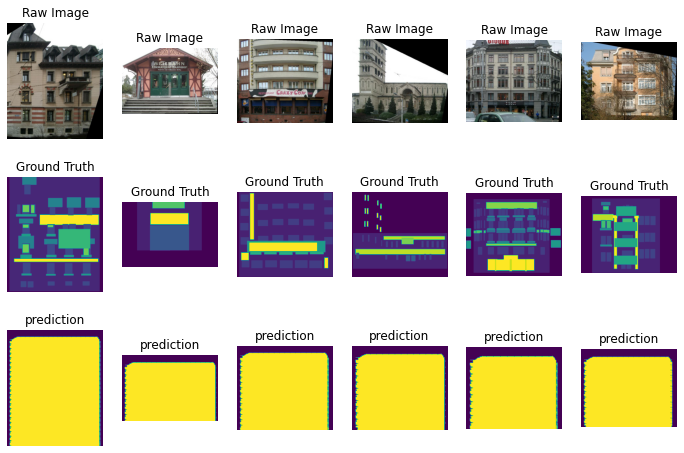

In [ ]:
visualize(best_model, test_loader)

## Utilize the pretrain features

In the previous section, we use the random initalized weights to train FCN-32S from scrath. We can see that it perform poorly. In this section, we utilize the feature from pretrained model(In our case, we use VGG-16) to help us get a better result.

In [ ]:
import torchvision
vgg16 = torchvision.models.vgg16(pretrained=True)

model = FCN32s(n_class=12)
model.copy_params_from_vgg16(vgg16)
model.to(device)

optim = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optim, 'min', patience=3,
    min_lr=1e-10, verbose=True
)

loss_func = nn.CrossEntropyLoss()
best_model_pretrain = Train(
    model,
    loss_func,
    optim,
    scheduler,
    25,
    train_loader,
    val_loader,
    test_loader
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Init Model
Avg Acc: 0.1593, Mean IoU: 0.03982
Epochs: 0
100 / 500, Current Avg Loss:1.754
200 / 500, Current Avg Loss:1.685
300 / 500, Current Avg Loss:1.583
400 / 500, Current Avg Loss:1.51
Avg Loss: 1.467, Avg Acc: 0.5802, Mean IoU: 0.2164
Epochs: 1
100 / 500, Current Avg Loss:1.16
200 / 500, Current Avg Loss:1.181
300 / 500, Current Avg Loss:1.176
400 / 500, Current Avg Loss:1.166
Avg Loss: 1.164, Avg Acc: 0.6108, Mean IoU: 0.2845
Epochs: 2
100 / 500, Current Avg Loss:1.069
200 / 500, Current Avg Loss:1.062
300 / 500, Current Avg Loss:1.052
400 / 500, Current Avg Loss:1.029
Avg Loss: 1.026, Avg Acc: 0.6368, Mean IoU: 0.3278
Epochs: 3
100 / 500, Current Avg Loss:0.9454
200 / 500, Current Avg Loss:0.9279
300 / 500, Current Avg Loss:0.9239
400 / 500, Current Avg Loss:0.9198
Avg Loss: 0.9205, Avg Acc: 0.6473, Mean IoU: 0.3453
Epochs: 4
100 / 500, Current Avg Loss:0.855
200 / 500, Current Avg Loss:0.8359
300 / 500, Current Avg Loss:0.8421
400 / 500, Current Avg Loss:0.8361
Avg Loss: 0.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


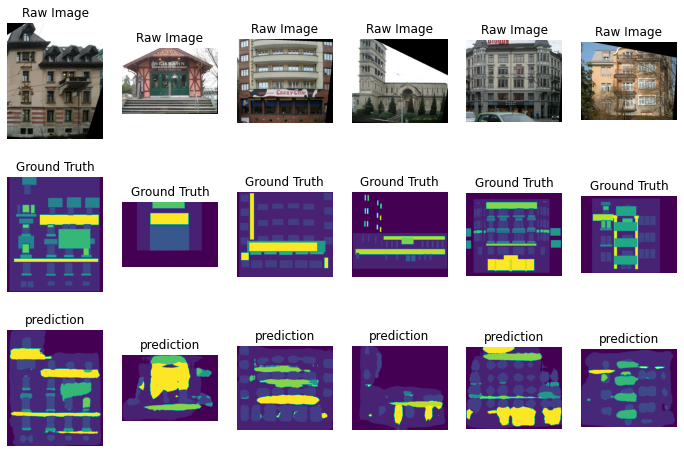

In [ ]:
visualize(best_model_pretrain, test_loader)

## Skip Connection: FCN-8s(40%)

Though we've get a prety good result using FCN-32s with VGG-16 pretrain. We can actully do better with another technique introduced in FCN paper: Skip Connection. 

With skip connection, we are supposed to get a better performance especially for some details.

Here we provide the structure of FCN-8s, the variant of FCN with skip connections.

FCN-8s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1(except conv1_1. conv1_1 should use padding = 100) **As you can see, the structure of this part is the same as FCN-32s**

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)] 
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] -> [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] -> [maxpool3(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] -> [maxpool3(2,2)]

The following Conv use kernel size = 7, stride = 1, padding = 0
* [fc6=conv(512, 4096, 7)-relu-dropout2d]

The following Conv use kernel size = 1, stride = 1, padding = 0
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The Additional Score Pool use kernel size = 1, stride = 1, padding = 0
* [score_pool_3 =conv1x1(256, num_classes)]
* [score_pool_4 =conv1x1(512, num_classes)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore1 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore2 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 16, stride = 8, bias = False
* [upscore3 = transpose_conv(n_class, n_class)]

Different from FCN-32s which has only single path from input to output, there are multiple data path from input to output in FCN-8s.

The following graph is from original FCN paper, you can also find the graph there.

!["Architecture Graph"](arch.png)
"Layers are shown as grids that reveal relative spatial coarseness. Only pooling and prediction layers are shown; intermediate convolution layers (including converted fully connected layers) are omitted. " ---- FCN

Detailed path specification:

* score_pool_3
    * input: output from layer "pool3"
    * take [9: 9 + upscore2_width], [9: 9 + upscore2_height]
    
* score_pool_4,
    * input: output from layer "pool4"
    * take [5: 5 + upscore1_width], [5: 5 + upscore1_height]


* upscore1
    * input: output from layer "score"

* upscore2:
    * input: output from layer "score_pool_4" + output from layer "upscore1"

* upscore3:
    * input: output from layer "score_pool_3" + output from layer "upscore2"
    * take [31: 31 + input_image_width], [31: 31 + input_image_height]


In [ ]:
import torch.nn as nn

class FCN8s(nn.Module):

    def __init__(self, n_class=12):
        super(FCN8s, self).__init__()

        # YOUR CODE HERE
        self.conv1_1 = nn.Conv2d(in_channels = 3, out_channels = 64,kernel_size=3,padding=100,stride=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(in_channels = 64, out_channels = 64,kernel_size=3,padding=1,stride=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride = 2, ceil_mode=True)

        self.conv2_1 = nn.Conv2d(in_channels = 64, out_channels = 128,kernel_size=3,padding=1,stride=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(in_channels = 128, out_channels = 128,kernel_size=3,padding=1,stride=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride = 2,ceil_mode=True)

        self.conv3_1 = nn.Conv2d(in_channels = 128, out_channels = 256,kernel_size=3,padding=1,stride=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(in_channels = 256, out_channels = 256,kernel_size=3,padding=1,stride=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(in_channels = 256, out_channels = 256,kernel_size=3,padding=1,stride=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride = 2, ceil_mode=True)

        self.conv4_1 = nn.Conv2d(in_channels = 256, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride = 2,ceil_mode=True)

        self.conv5_1 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size=3,padding=1,stride=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride = 2, ceil_mode=True)

        self.fc6 = nn.Conv2d(in_channels = 512, out_channels = 4096,kernel_size=7,padding=0,stride=1)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(in_channels = 4096, out_channels = 4096,kernel_size=1,padding=0,stride=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_convolution = nn.Conv2d(in_channels = 4096, out_channels = 12, kernel_size=1, padding=0, stride=1)

        self.score_pool_3 = nn.Conv2d(in_channels = 256, out_channels = 12, kernel_size=1,padding=0,stride=1)
        self.score_pool_4 = nn.Conv2d(in_channels = 512, out_channels = 12,kernel_size=1,padding=0,stride=1)


        self.upscore1 = nn.ConvTranspose2d(in_channels = 12, out_channels = 12,kernel_size=4,stride=2,bias=False)
        self.upscore2 = nn.ConvTranspose2d(in_channels = 12, out_channels = 12,kernel_size=4,stride=2,bias=False)
        self.upscore3 = nn.ConvTranspose2d(in_channels = 12, out_channels = 12,kernel_size=16,stride=8,bias=False)

        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

                
    def forward(self, x):

        # YOUR CODE HERE
        _,_,input_image_height,input_image_width = x.shape

        part_11 = self.relu1_1(self.conv1_1(x))
        part_12 = self.conv1_2(part_11)
        part_13 = self.relu1_2(part_12)
        layer1 = self.pool1(part_13)
        
        part_21 = self.relu2_1(self.conv2_1(layer1))
        part_22 = self.conv2_2(part_21)
        layer2 = self.pool2(self.relu2_2(part_22))
        
        part_31 = self.relu3_1(self.conv3_1(layer2))
        part_32 = self.relu3_2(self.conv3_2(part_31))
        part_33 = self.conv3_3(part_32)
        layer3 = self.pool3(self.relu3_3(part_33))
        
        part_41 = self.relu4_1(self.conv4_1(layer3))
        part_42 = self.relu4_2(self.conv4_2(part_41))
        part_43 = self.relu4_3(self.conv4_3(part_42))
        layer4 = self.pool4(part_43)
        
        part_51 = self.relu5_1(self.conv5_1(layer4))
        part_52 = self.relu5_2(self.conv5_2(part_51))
        part_53 = self.relu5_3(self.conv5_3(part_52))
        layer5 = self.pool5(part_53)

        layer6 = self.drop6(self.relu6(self.fc6(layer5)))

        layer7 = self.drop7(self.relu7(self.fc7(layer6)))

        upscore1 = self.upscore1(self.score_convolution(layer7))
        
        score_pool_4 = self.score_pool_4(layer4)[:, :, 5:(5 + upscore1.size()[2]), 5:(5 + upscore1.size()[3])]

        upscore2 = self.upscore2(score_pool_4 + upscore1)
    
        score_pool_3 = self.score_pool_3(layer3)[:, :,9:(9 + upscore2.size()[2]),9:(9 + upscore2.size()[3])]

        upscore3 = self.upscore3(score_pool_3 + upscore2)

        to_return = upscore3[:, :, 31:(31 + x.size()[2]), 31:(31 + x.size()[3])]
        
        h = to_return

        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


In [ ]:
import torchvision
vgg16 = torchvision.models.vgg16(pretrained=True)

model = FCN8s(n_class=12)
model.copy_params_from_vgg16(vgg16)
model.to(device)

optim = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
#     momentum=momentum,
)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optim, 'min', patience=3,
    min_lr=1e-10, verbose=True
)
loss_func = nn.CrossEntropyLoss()
best_model_fcn8s = Train(
    model,
    loss_func,
    optim,
    scheduler,
    25,
    train_loader,
    val_loader,
    test_loader
)

Init Model
Avg Acc: 0.2305, Mean IoU: 0.01921
Epochs: 0
100 / 500, Current Avg Loss:1.564
200 / 500, Current Avg Loss:1.416
300 / 500, Current Avg Loss:1.318
400 / 500, Current Avg Loss:1.247
Avg Loss: 1.203, Avg Acc: 0.6096, Mean IoU: 0.301
Epochs: 1
100 / 500, Current Avg Loss:0.9171
200 / 500, Current Avg Loss:0.957
300 / 500, Current Avg Loss:0.9581
400 / 500, Current Avg Loss:0.9575
Avg Loss: 0.9572, Avg Acc: 0.6496, Mean IoU: 0.3416
Epochs: 2
100 / 500, Current Avg Loss:0.8804
200 / 500, Current Avg Loss:0.891
300 / 500, Current Avg Loss:0.8698
400 / 500, Current Avg Loss:0.8719
Avg Loss: 0.8625, Avg Acc: 0.6669, Mean IoU: 0.3793
Epochs: 3
100 / 500, Current Avg Loss:0.8242
200 / 500, Current Avg Loss:0.7978
300 / 500, Current Avg Loss:0.8102
400 / 500, Current Avg Loss:0.8072
Avg Loss: 0.8, Avg Acc: 0.6809, Mean IoU: 0.398
Epochs: 4
100 / 500, Current Avg Loss:0.7312
200 / 500, Current Avg Loss:0.732
300 / 500, Current Avg Loss:0.7242
400 / 500, Current Avg Loss:0.7318
Avg Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


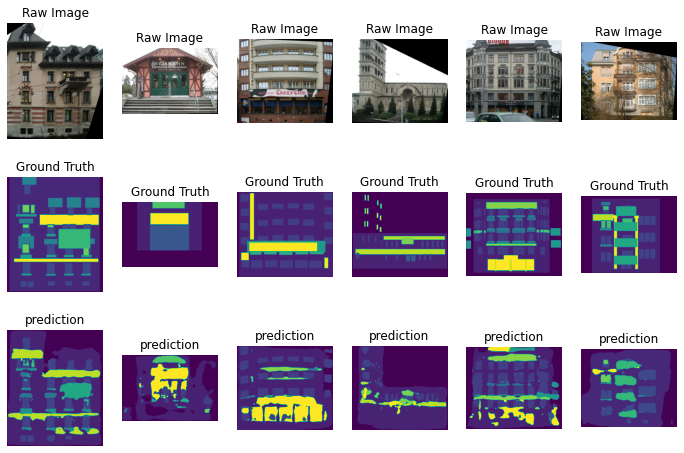

In [ ]:
visualize(best_model_fcn8s, test_loader)

## Inline Questions(30%):

#### Inline Question 1: Why using pretrained model to initialized our model(FCN-32s) helps a lot? Please give at least two specific reasons

### Your Answer: Utilizing the features from pretrained model to intialize our FCN-32s model greatly improved performance. This is fundamentally transfer learning and it is has many reasons. This massive increase in performance while using the pretrained model can be largely attribited to the pretrained model being trained on a much larger dataset and perhaps even a greater number of classes, making the pretrained model a much better model and hence the increase in performance. The second and the biggest reason justifying the use of pretrained models (especially in our case with limited time and resources), the pretained model takes significantly less time to train and run. In summary, the time to train is significnatly less while the accuracy is greatly improved.



#### Inline Question 2: Compare the performance and visualization of FCN-32s and FCN-8s. Please state the differnece, and provide some explanation. You can visualize more images than we provide, if it's necessary for you to see the difference.

### Your Answer: The test accuracy of FCN-32 is 0.7207 and Test Mean IoU is 0.4749. For FCN-8, the test accuracy is 0.7472 and Test Mean IoU is 0.511. Therefore it is clear that while the performance of FCN-32 and FCN-8 are almost identical, FCN-8 is slightly better. This difference in performance is even more apparent when we start looking at the predictions of both networks. Looking at the details like window panes in the visualized predicted images, FCN-32's predictions are much more chuckier and blobier when compared to FCN-8's predictions are more attentive to details and instead of predicting windows as just huge blobs, there windows are more defined. In the deeper FCN-32 newtwork, while we are able to get more specific, deep features, we also loose spacial information and hence a much blobier predictions when compared to those of the shallower FCN-8 network. 